<a href="https://colab.research.google.com/github/jvwk/Project-2/blob/main/Project_2_part_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 2 Part 4
## *Jaco van Wyk*

------------


# Part 1
(Abridged)

**Source of data**

>  https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset

<br>

**Brief description of data**

>According to the World Health Organization (WHO) stroke is the 2nd leading cause of death globally, responsible for approximately 11% of total deaths.
>
>This dataset is used to predict whether a patient is likely to get stroke based on the input parameters like gender, age, various diseases, and smoking status. Each row in the data provides relavant information about the patient.

<br>

**Target**

>*stroke* is the target: 1 if the patient had a stroke or 0 if not

# Part 2

**Load and inspect data**

In [228]:



import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [229]:
# Import relevant libraries

from sklearn import set_config
set_config(transform_output='pandas')

from google.colab import drive
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from seaborn import heatmap
from statistics import mode

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from xgboost import XGBClassifier


In [230]:
# Mount google drive and load data

drive.mount('/content/drive')
file = '/content/drive/MyDrive/CodingDojo/03-AdvancedML/Week09/Data/healthcare_dataset_stroke_data.csv'
df = pd.read_csv(file)
df.set_index('id', inplace = True, verify_integrity = True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [231]:
# Inspect data
print('Data frame shape: ', df.shape,'\n'*2)
print(df.info(),'\n'*2)
df.head()

Data frame shape:  (5110, 11) 


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5110 entries, 9046 to 44679
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 479.1+ KB
None 




,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


There are no unnecessary columns

**Data cleaning**

In [232]:
# Assess data for duplicate rows
df.duplicated().sum()

0

There are no duplicates

In [233]:
# Assess data for missing values

miss_vals = pd.DataFrame({'Number missing': df.isna().sum()})
miss_val_pc = pd.DataFrame({'Percentage missing': df.isna().sum()/len(df)*100})
missing = pd.concat([miss_vals, miss_val_pc], axis = 1)
display(missing.round(2))

,Number missing,Percentage missing
gender,0,0.00
age,0,0.00
hypertension,0,0.00
heart_disease,0,0.00
ever_married,0,0.00
work_type,0,0.00
Residence_type,0,0.00
avg_glucose_level,0,0.00
bmi,201,3.93
smoking_status,0,0.00


BMI has 201 (3.93%) missing values

- Impute at pre-processing stage

In [234]:
# Assess data for inconsistent entries in categorical columns

num_vals = df.select_dtypes('number').columns
cat_cols = df.select_dtypes('object').columns
for i in cat_cols:
  print(f'Values for {i}:\n')
  print(df[{i}].value_counts())
  print("\n")

Values for gender:

gender
Female    2994
Male      2115
Other        1
dtype: int64


Values for ever_married:

ever_married
Yes             3353
No              1757
dtype: int64


Values for work_type:

work_type    
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
dtype: int64


Values for Residence_type:

Residence_type
Urban             2596
Rural             2514
dtype: int64


Values for smoking_status:

smoking_status 
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
dtype: int64




There are no inconsistent values in categorical columns

**Univariate visuals**

In [235]:
# Change numerical binaries (hypertension and heart disease) to categorical
df[['hypertension', 'heart_disease', 'stroke']] = df[['hypertension', 'heart_disease', 'stroke']].astype('string')

In [236]:
# Recategorise columns by type
num_vals = df.select_dtypes('number').columns
cat_cols = df.select_dtypes('object').columns

In [237]:
# Create colour palette reference table and store in dataframe for displaying names and hexcodes
# From code snippets - "Pandas DataFrame: Create from lists of values"
# from https://python.plainenglish.io/how-to-make-your-own-color-palette-with-matplotlib-in-python-2494e78694e

colour_names = ["darkblue", "red", "bluegrey", "orange", "green", "purple", "yellow", "darkgreen", "pink"]
colour_codes = ["#003365","#E61A1F", "#489CBA", "#FE6801", "#00B050", "#5C2F88", "#FDB211", "#506600", "#FF71BF"]
colour_df = pd.DataFrame({
  'colour_name': colour_names,
  'colour_code': colour_codes,
})

colour_df

,colour_name,colour_code
0,darkblue,#003365
1,red,#E61A1F
2,bluegrey,#489CBA
3,orange,#FE6801
4,green,#00B050
5,purple,#5C2F88
6,yellow,#FDB211
7,darkgreen,#506600
8,pink,#FF71BF


In [238]:
# UNIVARIATE PLOTTING FUNCTIONS
# Adapted from codingdojo course notes

def explore_categorical(df, x, fillna = True, placeholder = 'MISSING',
                        figsize = (6,4), color=None, order = None, palette=None):
  """
  Creates a seaborn countplot with the option to temporarily fill missing values
  Prints statements about null values, cardinality, and checks for
  constant/quasi-constant features.
  """
  # Make a copy of the dataframe and fillna
  temp_df = df.copy()

  # Before filling nulls, save null value counts and percent for printing
  null_count = temp_df[x].isna().sum()
  null_perc = null_count/len(temp_df)* 100

  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)

  # Create figure with desired figsize
  fig, ax = plt.subplots(figsize=figsize)

  # Countplot
  sns.countplot(data=temp_df, x=x, ax=ax, order=order, alpha = 0.8)

  # Rotate tick Labels for long names
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center')

  # Add a title with the feature name included
  ax.set_title(f"{x} distribution", fontweight='bold')

  # Fix layout and show plot (before print statements)
  fig.tight_layout()
  plt.show()

  # Print null value info
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")

  # Print cardinality info
  nunique = temp_df[x].nunique()
  print(f"- Unique Values: {nunique}")

  # First find value counts of feature
  val_counts = temp_df[x].value_counts(dropna=False)

  # Define the most common value
  most_common_val = val_counts.index[0]

  # Define the frequency of the most common value
  freq = val_counts.values[0]

  # Calculate the percentage of the most common value
  perc_most_common = freq / len(temp_df) * 100

  # Print the results
  print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")

  # print message if quasi-constant or constant (most common val more than 98% of data)
  if perc_most_common > 98:
    print(f"\n- [!] Warning: '{x}' is a constant or quasi-constant feature and should be dropped.")
  else:
    print("- Not constant or quasi-constant.")
  print('\n'*2)
  return fig, ax

def explore_numeric(df, x, figsize=(6,5), color = 'w'):
  """
  Creates a seaborn histplot and boxplot with a share x-axis,
  Prints statements about null values, cardinality, and checks for
  constant/quasi-constant features.
  """

  # Save null value counts and percent for printing
  null_count = df[x].isna().sum()
  null_perc = null_count/len(df)* 100

  # Making our figure with gridspec for subplots
  gridspec = {'height_ratios':[0.7,0.3]}
  fig, axes = plt.subplots(nrows=2, figsize=figsize,
                           sharex=True, gridspec_kw=gridspec)
  # Histogram on Top
  sns.histplot(data=df, x=x, ax=axes[0], ec = 'white', color=color, alpha = 0.5)

  # Boxplot on Bottom
  sns.boxplot(data=df, x=x, ax=axes[1], fliersize = 2, color = colour, boxprops=dict(alpha=0.5))

  # Adding a title
  axes[0].set_title(f"{x} distribution", fontweight='bold')

  # Adjusting subplots to best fill Figure
  fig.tight_layout()

  # Ensure plot is shown before message
  plt.show()

  # Print null value info
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")
  # Print cardinality info
  nunique = df[x].nunique()
  print(f"- Unique Values: {nunique}")

  # Get the most most common value, its count as # and as %
  most_common_val_count = df[x].value_counts(dropna=False).head(1)
  most_common_val = most_common_val_count.index[0]
  freq = most_common_val_count.values[0]
  perc_most_common = freq / len(df) * 100

  print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")

  # print message if quasi-constant or constant (most common val more than 98% of data)
  if perc_most_common > 98:
    print(f"\n- [!] Warning: '{x}' is a constant or quasi-constant feature and should be dropped.")
  else:
    print("- Not constant or quasi-constant.")
  print('\n'*2)
  return fig, axes

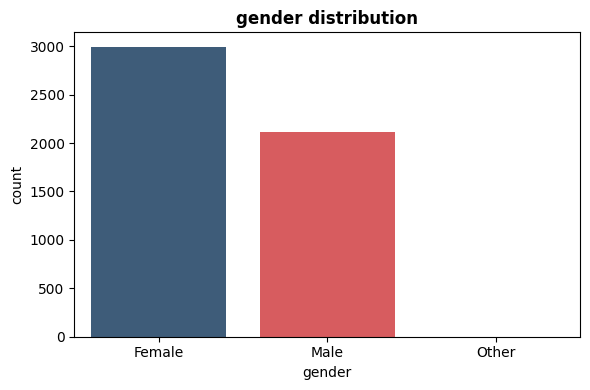

- NaN's Found: 0 (0.0%)
- Unique Values: 3
- Most common value: 'Female' occurs 2994 times (58.59%)
- Not constant or quasi-constant.





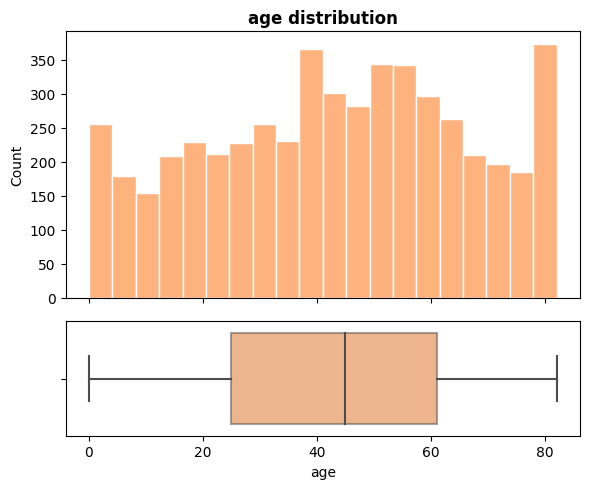

- NaN's Found: 0 (0.0%)
- Unique Values: 104
- Most common value: '78.0' occurs 102 times (2.0%)
- Not constant or quasi-constant.





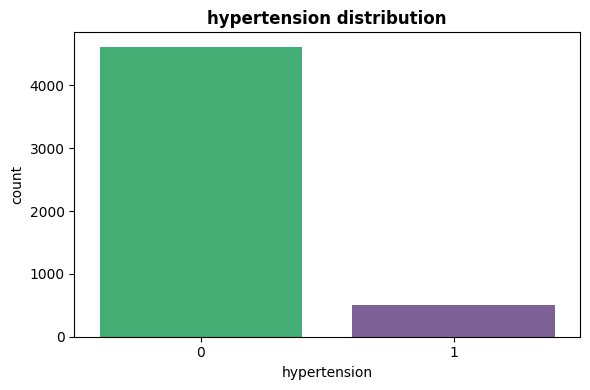

- NaN's Found: 0 (0.0%)
- Unique Values: 2
- Most common value: '0' occurs 4612 times (90.25%)
- Not constant or quasi-constant.





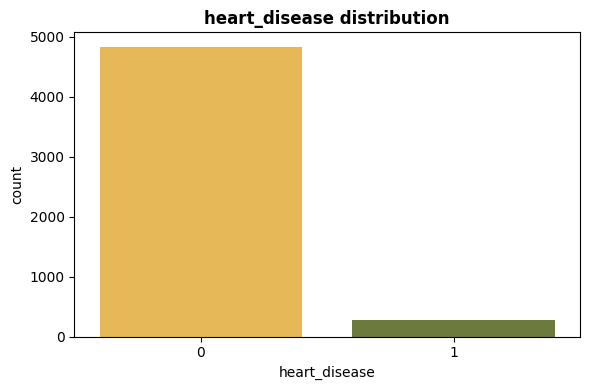

- NaN's Found: 0 (0.0%)
- Unique Values: 2
- Most common value: '0' occurs 4834 times (94.6%)
- Not constant or quasi-constant.





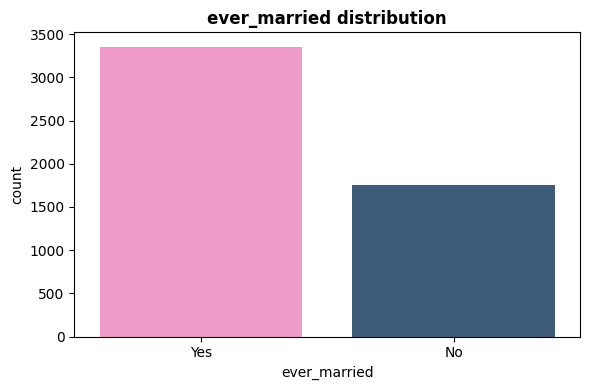

- NaN's Found: 0 (0.0%)
- Unique Values: 2
- Most common value: 'Yes' occurs 3353 times (65.62%)
- Not constant or quasi-constant.





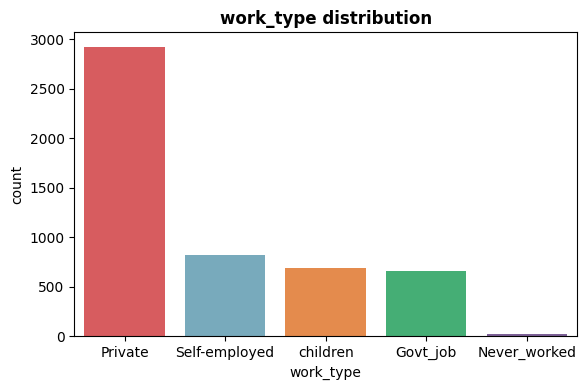

- NaN's Found: 0 (0.0%)
- Unique Values: 5
- Most common value: 'Private' occurs 2925 times (57.24%)
- Not constant or quasi-constant.





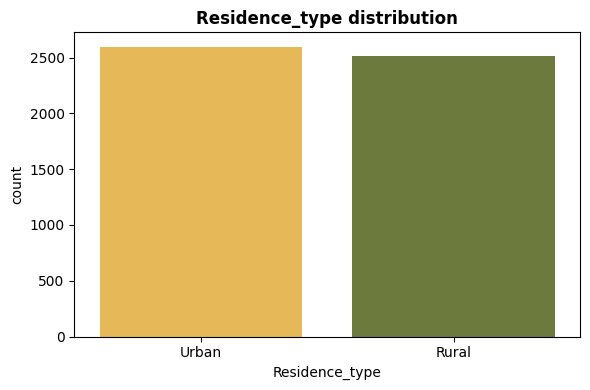

- NaN's Found: 0 (0.0%)
- Unique Values: 2
- Most common value: 'Urban' occurs 2596 times (50.8%)
- Not constant or quasi-constant.





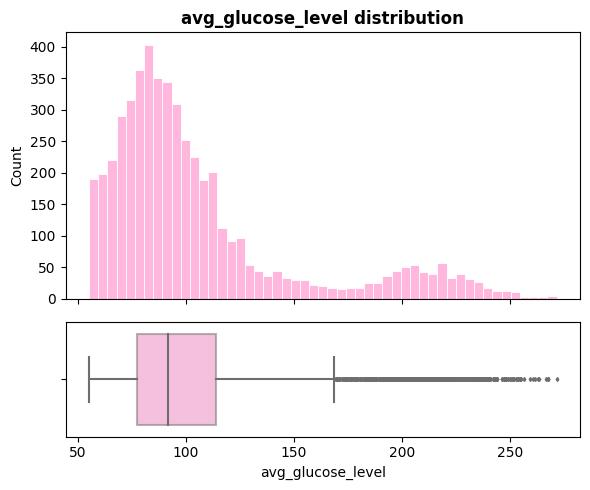

- NaN's Found: 0 (0.0%)
- Unique Values: 3979
- Most common value: '93.88' occurs 6 times (0.12%)
- Not constant or quasi-constant.





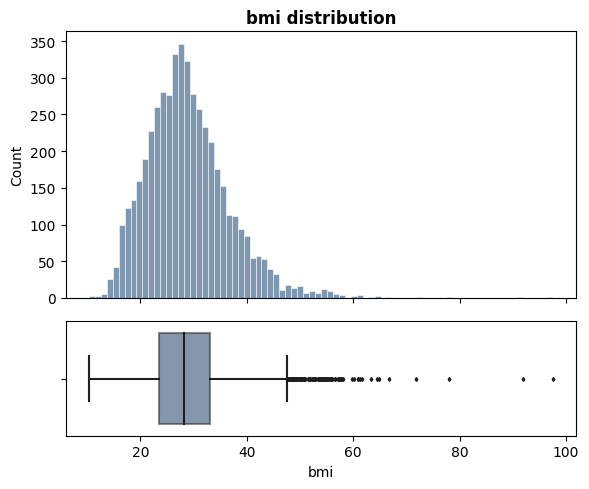

- NaN's Found: 201 (3.93%)
- Unique Values: 418
- Most common value: 'nan' occurs 201 times (3.93%)
- Not constant or quasi-constant.





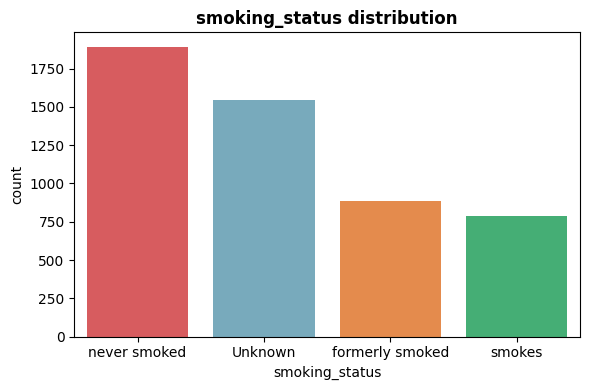

- NaN's Found: 0 (0.0%)
- Unique Values: 4
- Most common value: 'never smoked' occurs 1892 times (37.03%)
- Not constant or quasi-constant.





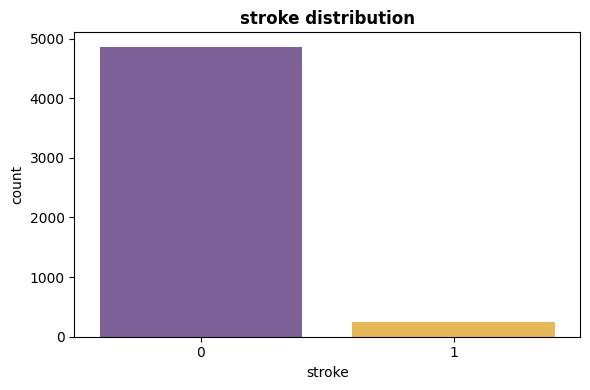

- NaN's Found: 0 (0.0%)
- Unique Values: 2
- Most common value: '0' occurs 4861 times (95.13%)
- Not constant or quasi-constant.





In [239]:
# Create appropriate plots based on data type

i = 0

for column in df.columns:

  # Rotate through colours in palette
  colour = colour_codes[i%len(colour_codes)]
  j = i%len(colour_codes)
  my_cols = colour_codes[j:] + colour_codes[:j]
  palette = sns.set_palette(sns.color_palette(my_cols))

  if not(df[column].dtype == "int" or df[column].dtype == "float"):
    order = df[column].value_counts().index

  # Run the appropriate explore function (based on columns's dtype)
  if df[column].dtype == "int" or df[column].dtype == "float":
    fig, ax = explore_numeric(df, x = column, color = colour)
    i += 1
  else:
    fig, ax = explore_categorical(df, x = column, order = order, fillna = False, placeholder = 'MISSING', palette = palette)
    i += df[column].nunique()

In [240]:
# Investigate BMI
df['bmi'].describe()

count    4909.000000
mean       28.893237
std         7.854067
min        10.300000
25%        23.500000
50%        28.100000
75%        33.100000
max        97.600000
Name: bmi, dtype: float64

BMI of 97.6 seems like an outlier; investigate further

In [241]:
# Assess height-weight combinations for BMI of 97.6

max_bmi = 97.6

height_range = [i/2 for i in range(2*130, 2*221, 5)]
df_maxbmi = pd.DataFrame({'height_cm': height_range})
df_maxbmi['weight_kg'] = (df_maxbmi['height_cm']/100)**2*max_bmi
df_maxbmi['height_in'] = df_maxbmi['height_cm']/2.54
df_maxbmi['height_ft'] = (df_maxbmi['height_in']//12).astype('int').astype('string') + "' " + round(df_maxbmi['height_in']%12,0).astype('int').astype('string') + '"'
df_maxbmi['weight_lb'] = df_maxbmi['weight_kg']*2.2
print(f'Heigh-weight combinations for BMI of {max_bmi}\n')
df_maxbmi.round(1)

Heigh-weight combinations for BMI of 97.6



,height_cm,weight_kg,height_in,height_ft,weight_lb
0,130.0,164.9,51.2,"4' 3""",362.9
1,132.5,171.3,52.2,"4' 4""",377.0
2,135.0,177.9,53.1,"4' 5""",391.3
3,137.5,184.5,54.1,"4' 6""",406.0
4,140.0,191.3,55.1,"4' 7""",420.9
5,142.5,198.2,56.1,"4' 8""",436.0
6,145.0,205.2,57.1,"4' 9""",451.4
7,147.5,212.3,58.1,"4' 10""",467.2
8,150.0,219.6,59.1,"4' 11""",483.1
9,152.5,227.0,60.0,"5' 0""",499.4


While BMI of 97.6 is exceedingly high, it is possible
- Keep as is

## Part 3

- Identify any moderate or strong correlations between  target and features and/or between one feature and another using a correlation heatmap
- Create multivariate exploratory visualisations to understand data and search for trends
- Choose two visualisations from the analysis that demonstrate key trends that will be of interest to a stakeholder
    - Reporting-quality with titles, labels, and a short explanation of the trend
    - Easily understood by a non-technical audience
    - Avoid histograms, boxplots, or correlation plots
- Explain in a text cell the insight associated with each visual

In [242]:
# MULTIVARIATE PLOTTING FUNCTIONS VS. CATEGORICAL TARGET
# Adapted from codingdojo course notes

def plot_numeric_vs_target(df, x, y, figsize=(6,4),
                            fillna = True, placeholder = 'MISSING',
                            order = None, palette = None):
  """
  Plots a combination of a seaborn barplot of means combined with
  a seaborn stripplot to show the spread of the data.
  """
  # Make a copy of the dataframe and fillna
  temp_df = df.copy()

  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)

  # or drop nulls prevent unwanted 'nan' group in stripplot
  else:
    temp_df = temp_df.dropna(subset=[x])

  # Create the figure and subplots
  fig, ax = plt.subplots(figsize=figsize)

  # Barplot
  sns.barplot(data = temp_df, x = x, y = y, ax = ax, order = order, alpha = 0.6,
              linewidth = 1, edgecolor = 'white', errorbar  = None)

  # Stripplot
  sns.stripplot(data = temp_df, x = x, y = y, hue = x, ax = ax,
                order = order, hue_order = order, legend=False,
                edgecolor = 'white', linewidth = 0.5,
                size = 3, zorder = 0, jitter = 0.3)

  # Rotate xlabels
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center')

  # Add a title
  ax.set_title(f"{y} versus {x}", fontweight='bold')
  fig.tight_layout()
  plt.show()
  print('\n'*2)
  return fig, ax

def plot_categorical_vs_target(df, x, y, figsize=(6,4),
                            fillna = True, placeholder = 'MISSING',
                            order = None, palette = None):
  """
  Plots a combination of a seaborn barplot of means combined with
  a seaborn stripplot to show the spread of the data.
  """
  # Make a copy of the dataframe and fillna
  temp_df = df.copy()

  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)

  # or drop nulls prevent unwanted 'nan' group in stripplot
  else:
    temp_df = temp_df.dropna(subset=[x])

  # Create the figure and subplots
  fig, ax = plt.subplots(figsize=figsize)

  # Countplot
  sns.countplot(data = temp_df, x = x, hue = y, ax = ax, order = order, alpha = 0.8,
              linewidth = 1, edgecolor = 'white')

  # Rotate xlabels
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center')

  # Add a title
  ax.set_title(f"{x} versus {y}", fontweight='bold')
  fig.tight_layout()
  plt.show()
  print('\n'*2)
  return fig, ax

**Correlation**

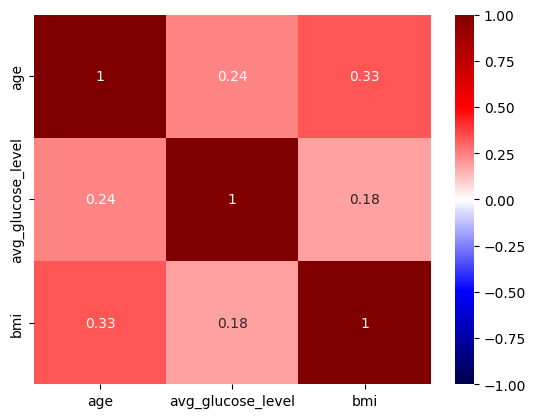

In [243]:
# Set up and show correlation matrix
corr = df.corr(numeric_only = True)
sns.heatmap(corr.round(2), cmap = 'seismic', annot = True, vmin = -1);

- There are no strong or moderate correlations between any numerical features
- There are no negative correlations between numerical features at all

**Multivariate exploratory visualisations**

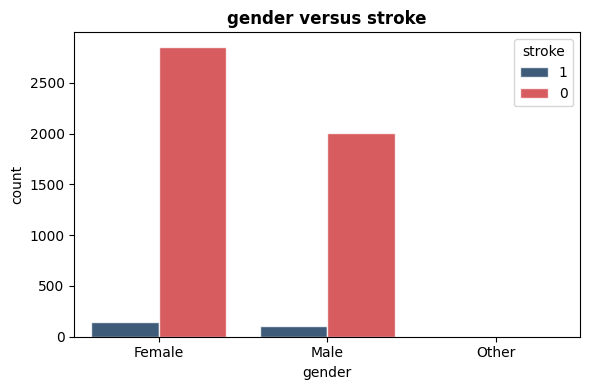

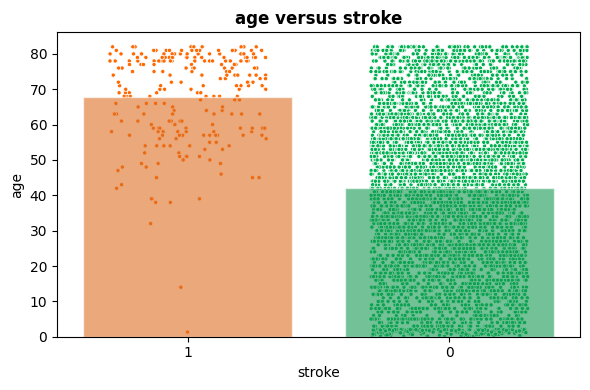

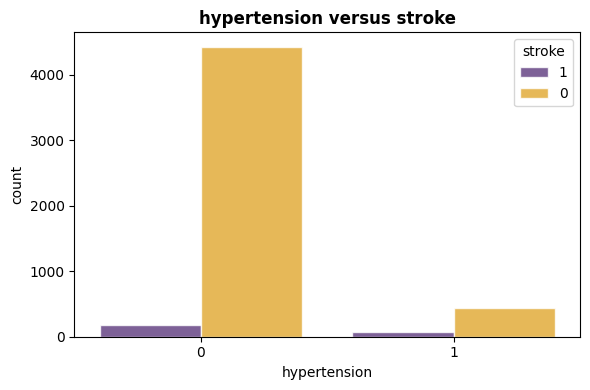

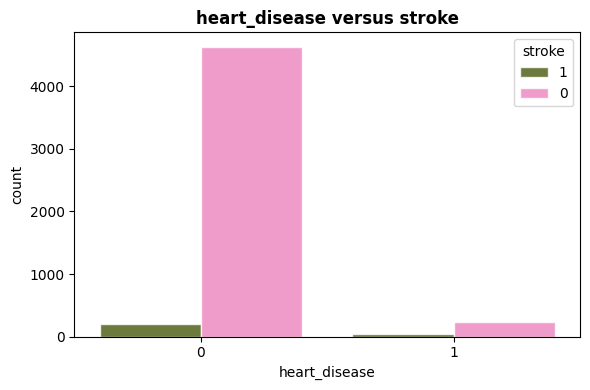

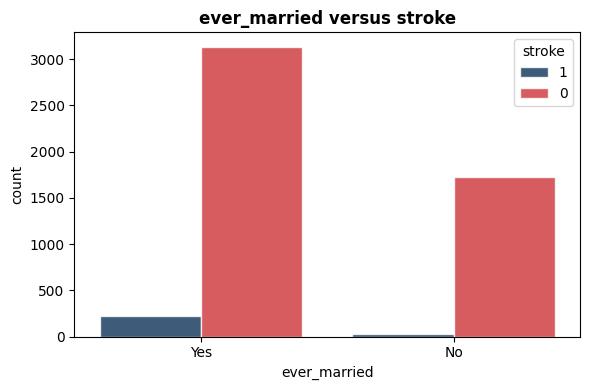

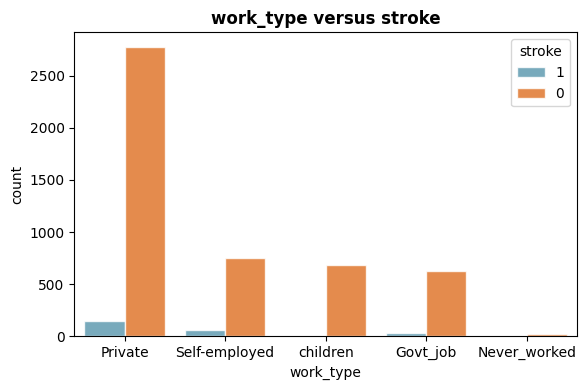

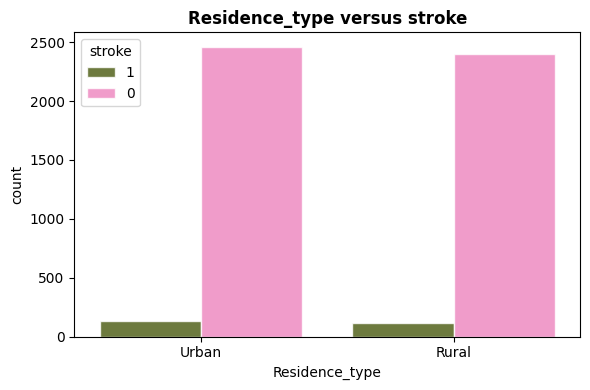

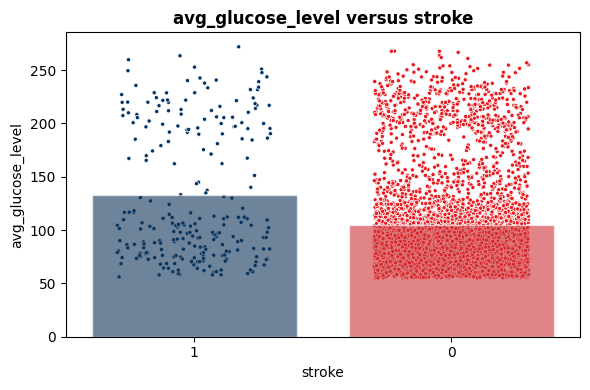

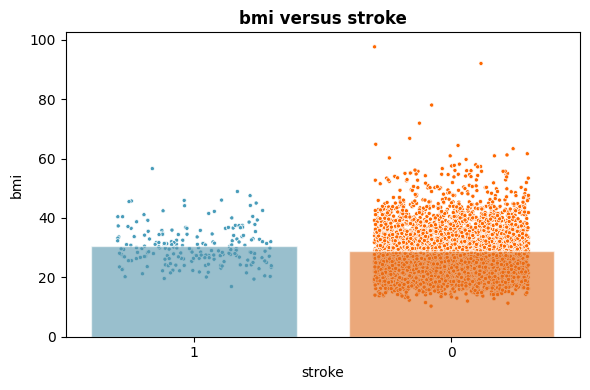

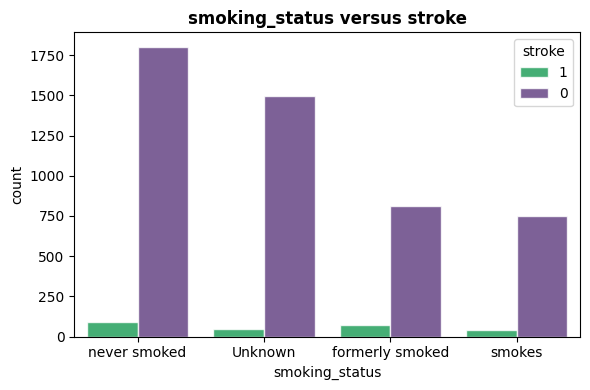

In [244]:
# Create appropriate plot for target

i = 0
target = 'stroke'
features = df.columns.drop(target)

for column in features:

  # Rotate through colours in palette
  colour = colour_codes[i%len(colour_codes)]
  j = i%len(colour_codes)
  my_cols = colour_codes[j:] + colour_codes[:j]
  palette = sns.set_palette(sns.color_palette(my_cols))

  if not(df[column].dtype == "int" or df[column].dtype == "float"):
    order = df[column].value_counts().index

  # Run the appropriate explore function (based on columns's dtype)
  if df[column].dtype == "int" or df[column].dtype == "float":
    fig, ax = plot_numeric_vs_target(df, y = column, x = target, palette = palette)
    i += df[target].nunique()
  else:
    fig, ax = plot_categorical_vs_target(df, x = column, y = target, fillna = False, order = order, palette = palette)
    i += df[column].nunique()


**Chosen visual 1: Age versus Stroke**

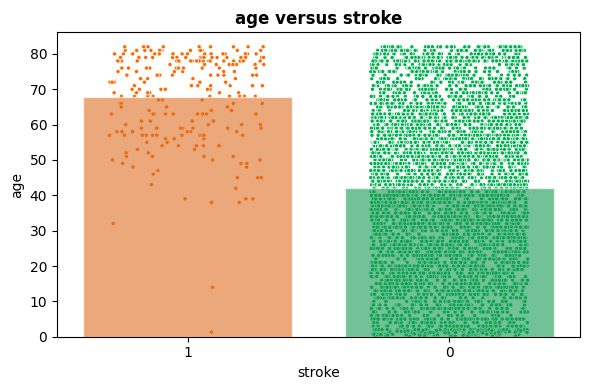

In [245]:
# Plot chosen visual 1

my_cols = colour_codes[3:] + colour_codes[:3]
palette = sns.set_palette(sns.color_palette(my_cols))

fig, ax = plot_numeric_vs_target(df, y = 'age', x = 'stroke', palette = palette)

The age distribution of stroke victims' ages is weighted towards older ages, while the age distribution of those who did not suffer strokes are far more evenly spread across the age range.

**Chosen visual 2: Hypertension versus Stroke**

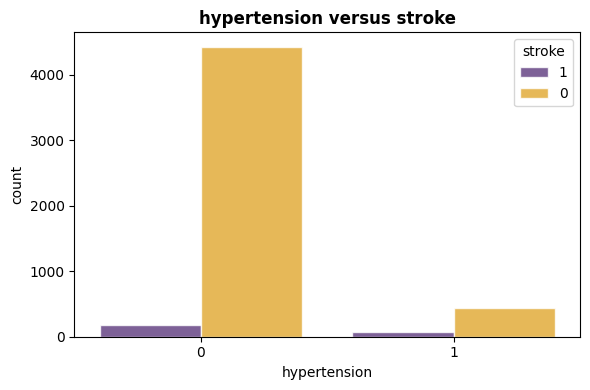

In [246]:
# Plot chosen visual 2

my_cols = colour_codes[5:] + colour_codes[:5]
palette = sns.set_palette(sns.color_palette(my_cols))

fig, ax = plot_categorical_vs_target(df, y = 'stroke', x = 'hypertension', palette = palette)

A larger potion of hypertensive patients fell victim to stroke than of non-hypertensive patients

# Part 4

**Metrics used**

The model is used to predict whether a person is at risk of suffering a stroke. The relative importance of high precision (avoiding false positives) and high recall (avoiding false negatives) depends on the actions taken when a person is identified as "at risk". Assuming at-risk individuals will not be subjected harsh and/or costly medical treatments, but rather advised to make health-seeking lifestyle changes (eg healthier diet, more exercise, smoking cessation, etc), recall is of relatively more importance:
- a false positive may lead to undesired alarm in a person that may not be at high risk, but possibly motivating him/her making lifestyle changes
- a false negative may lull a person into a false sense of security in terms of stroke risk, and no motivation to make lifestyle changes

If false positives may lead to harsh or costly medical treatments, it may be advisable to consider the f1-score instead. This metric combines measures for  false negatives and false positives.

## Pre-processing

In [247]:
# Investigate missing BMI values
print('Stroke distribution for records with valid BMI:')
print(round(df[~df['bmi'].isna()]['stroke'].value_counts()/len(df[~df['bmi'].isna()])*100,1))
print('\n')
print('Stroke distribution for records with missing BMI:')
print(round(df[df['bmi'].isna()]['stroke'].value_counts()/len(df[df['bmi'].isna()])*100,1))

Stroke distribution for records with valid BMI:
0    95.7
1     4.3
Name: stroke, dtype: Float64


Stroke distribution for records with missing BMI:
0    80.1
1    19.9
Name: stroke, dtype: Float64


In [248]:
# Drop rows with missing bmi values
df = df.dropna(subset=["bmi"])

In [249]:
# Check if dropping missng bmi values was successful
df.shape

(4909, 11)

Amongst records with missing BMI values the percentage of patients who suffered a stroke is four times higher than amongst those with valid BMI values. Missing BMI values may therefore not be randomly distributed over stroke status. Hence, remove records without BMI instead of imputation with a meausre of central tendency.

In [250]:
# Instantiate numerical preprocessors and pipeline
scaler_num = StandardScaler()
num_pipe = make_pipeline(scaler_num)
num_pipe

Pipeline(steps=[('standardscaler', StandardScaler())])

In [251]:
# Instantiate nominal preprocessors and pipeline
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
ohe_pipe = make_pipeline(ohe_encoder)
ohe_pipe

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

In [252]:
# Making a numeric tuple for ColumnTransformer
num_tuple = ('numeric', num_pipe, num_vals)
num_tuple

('numeric',
 Pipeline(steps=[('standardscaler', StandardScaler())]),
 Index(['age', 'avg_glucose_level', 'bmi'], dtype='object'))

In [253]:
# Making a ohe_tuple for ColumnTransformer
ohe_tuple = ('categorical', ohe_pipe, cat_cols)
ohe_tuple

('categorical',
 Pipeline(steps=[('onehotencoder',
                  OneHotEncoder(handle_unknown='ignore', sparse_output=False))]),
 Index(['gender', 'ever_married', 'work_type', 'Residence_type',
        'smoking_status'],
       dtype='object'))

In [254]:
# Use the tuples to create a ColumnTransformer to preprocess the data; set verbose_feature_names_out to False
col_transformer = ColumnTransformer([num_tuple, ohe_tuple],
                                    verbose_feature_names_out=False)
col_transformer

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 Index(['age', 'avg_glucose_level', 'bmi'], dtype='object')),
                                ('categorical',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['gender', 'ever_married', 'work_type', 'Residence_type',
       'smoking_status'],
      dtype='object'))],
                  verbose_feature_names_out=False)

In [255]:
# Assign features (X) and target (y)

# The target we are trying to predict
# y = df['stroke']
y = df.assign(stroke = pd.to_numeric(df['stroke']))['stroke']
# The features we will use to make the prediction
X = df.drop(columns = ['stroke'])
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
id,,,,,,,,,,
60777,Female,31.0,0,0,Yes,Govt_job,Rural,103.55,20.5,formerly smoked
65688,Male,2.0,0,1,No,children,Urban,62.89,29.4,Unknown
61010,Female,60.0,0,0,Yes,Private,Urban,114.34,30.3,smokes
15225,Male,18.0,0,0,No,Private,Rural,108.87,21.5,Unknown
57263,Female,54.0,0,0,Yes,Private,Urban,100.29,30.2,never smoked


## Apply default models without PCA

In [256]:
def eval_classification(model, X_train, X_test, y_train, y_test):
  print('Train Report:\n', classification_report(y_train, model.predict(X_train)))
  print('Test Report:\n', classification_report(y_test, model.predict(X_test)))

  cm = confusion_matrix(y_test, model.predict(X_test))

  plt.figure(figsize=(4, 4))
  heatmap(cm, annot=True, fmt='.0f')
  plt.xlabel('Predicted', fontsize=12)
  plt.ylabel('True', fontsize=12)
  plt.show()

In [257]:
# Make an instance of the decision tree model with default parameters and balanced class weight
dectree = DecisionTreeClassifier(class_weight = 'balanced')
# Put column transformer and model in a pipeline
dectree_pipe = make_pipeline(col_transformer, dectree)

# Training the model on the data, storing the information learned from the data
dectree_pipe.fit(X_train, y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'avg_glucose_level', 'bmi'], dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['gender', 'ever_married', 'work_type', 'Residence_type',
       'smoking_status'],
      dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(class_weight='balanced'))])

In [258]:
# Make an instance of the logreg model with default parameters and balanced class weight
logreg = LogisticRegression(C = 1000, solver = 'liblinear', class_weight = 'balanced')
# Put column tranformer and model in a pipeline
logreg_pipe = make_pipeline(col_transformer, logreg)

# Training the model on the data, storing the information learned from the data
logreg_pipe.fit(X_train, y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'avg_glucose_level', 'bmi'], dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['gender', 'ever_married', 'work_type', 'Residence_type',
       'smoking_status'],
      dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('logisticregression',
                 LogisticRegression(C=1000, class_weight='balanced',
                                    solver='liblinear'))])

In [259]:
# Make an instance of the random forest model with default parameters and balanced class weight
rf = RandomForestClassifier(class_weight = 'balanced')
# Put column transformer and model in a pipeline
rf_pipe = make_pipeline(col_transformer, rf)

# Training the model on the data, storing the information learned from the data
rf_pipe.fit(X_train, y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'avg_glucose_level', 'bmi'], dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['gender', 'ever_married', 'work_type', 'Residence_type',
       'smoking_status'],
      dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced'))])

In [260]:
# Make an instance of the XGBoost model with default parameters
xgb = XGBClassifier()
# Put column transformer and model in a pipeline
xgb_pipe = make_pipeline(col_transformer, xgb)

# Training the model on the data, storing the information learned from the data
xgb_pipe.fit(X_train, y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'avg_glucose_level', 'bmi'], dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['gender', 'ever_married', 'work_type', 'Resid...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

## Evaluate models without PCA

Train Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3535
           1       1.00      1.00      1.00       146

    accuracy                           1.00      3681
   macro avg       1.00      1.00      1.00      3681
weighted avg       1.00      1.00      1.00      3681

Test Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.96      1165
           1       0.11      0.08      0.09        63

    accuracy                           0.92      1228
   macro avg       0.53      0.52      0.52      1228
weighted avg       0.91      0.92      0.91      1228



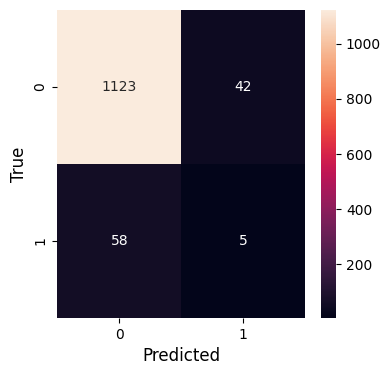

In [261]:
# Evaluate the decision tree pipeline
eval_classification(dectree_pipe, X_train, X_test, y_train, y_test)

Train Report:
               precision    recall  f1-score   support

           0       0.99      0.72      0.83      3535
           1       0.11      0.81      0.19       146

    accuracy                           0.73      3681
   macro avg       0.55      0.76      0.51      3681
weighted avg       0.95      0.73      0.81      3681

Test Report:
               precision    recall  f1-score   support

           0       0.99      0.72      0.83      1165
           1       0.14      0.83      0.24        63

    accuracy                           0.72      1228
   macro avg       0.56      0.77      0.53      1228
weighted avg       0.94      0.72      0.80      1228



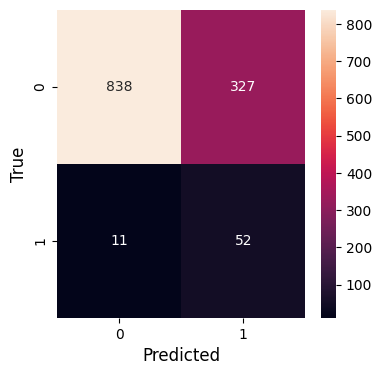

In [262]:
# Evaluate the logreg pipeline
eval_classification(logreg_pipe, X_train, X_test, y_train, y_test)

Train Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3535
           1       1.00      0.99      1.00       146

    accuracy                           1.00      3681
   macro avg       1.00      1.00      1.00      3681
weighted avg       1.00      1.00      1.00      3681

Test Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97      1165
           1       0.00      0.00      0.00        63

    accuracy                           0.95      1228
   macro avg       0.47      0.50      0.49      1228
weighted avg       0.90      0.95      0.92      1228



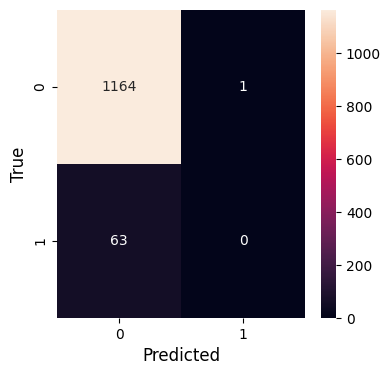

In [263]:
# Evaluate the random forest pipeline
eval_classification(rf_pipe, X_train, X_test, y_train, y_test)

Train Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3535
           1       1.00      0.95      0.98       146

    accuracy                           1.00      3681
   macro avg       1.00      0.98      0.99      3681
weighted avg       1.00      1.00      1.00      3681

Test Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97      1165
           1       0.17      0.02      0.03        63

    accuracy                           0.95      1228
   macro avg       0.56      0.51      0.50      1228
weighted avg       0.91      0.95      0.92      1228



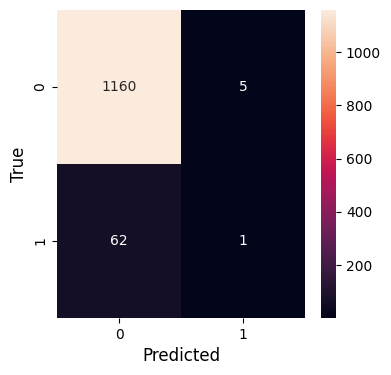

In [264]:
# Evaluate the XGBoost pipeline
eval_classification(xgb_pipe, X_train, X_test, y_train, y_test)

## Apply default models with PCA

In [265]:
# Employ PCA
pca = PCA(n_components = 0.95)

In [266]:
# Put column transformer and model in a pipeline
dectree_pipe_pca = make_pipeline(col_transformer, pca, dectree)

# Training the model on the data, storing the information learned from the data
dectree_pipe_pca.fit(X_train, y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'avg_glucose_level', 'bmi'], dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['gender', 'ever_married', 'work_type', 'Residence_type',
       'smoking_status'],
      dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('pca', PCA(n_components=0.95)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(class_weight='balanced'))])

In [267]:
# Put column tranformer and model in a pipeline
logreg_pipe_pca = make_pipeline(col_transformer, pca, logreg)

# Training the model on the data, storing the information learned from the data
logreg_pipe_pca.fit(X_train, y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'avg_glucose_level', 'bmi'], dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['gender', 'ever_married', 'work_type', 'Residence_type',
       'smoking_status'],
      dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('pca', PCA(n_components=0.95)),
                ('logisticregression',
                 LogisticRegression(C=1000, class_weight='balanced',
                                    solver='liblinear'))])

In [268]:
# Put column transformer and model in a pipeline
rf_pipe_pca = make_pipeline(col_transformer, pca, rf)

# Training the model on the data, storing the information learned from the data
rf_pipe_pca.fit(X_train, y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'avg_glucose_level', 'bmi'], dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['gender', 'ever_married', 'work_type', 'Residence_type',
       'smoking_status'],
      dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('pca', PCA(n_components=0.95)),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced'))])

In [269]:
# Put column transformer and model in a pipeline
xgb_pipe_pca = make_pipeline(col_transformer, pca, xgb)

# Training the model on the data, storing the information learned from the data
xgb_pipe_pca.fit(X_train, y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'avg_glucose_level', 'bmi'], dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['gender', 'ever_married', 'work_type', 'Resid...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

## Evaluate models with PCA

Train Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3535
           1       1.00      1.00      1.00       146

    accuracy                           1.00      3681
   macro avg       1.00      1.00      1.00      3681
weighted avg       1.00      1.00      1.00      3681

Test Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96      1165
           1       0.17      0.11      0.13        63

    accuracy                           0.93      1228
   macro avg       0.56      0.54      0.55      1228
weighted avg       0.91      0.93      0.92      1228



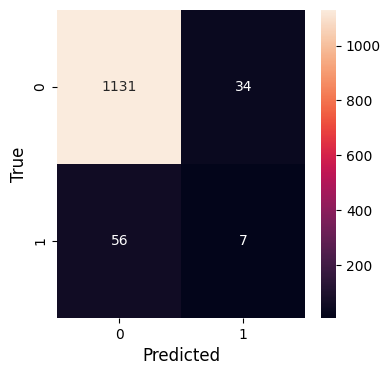

In [270]:
# Evaluate the decision tree pipeline with PCA
eval_classification(dectree_pipe_pca, X_train, X_test, y_train, y_test)

Train Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3535
           1       1.00      1.00      1.00       146

    accuracy                           1.00      3681
   macro avg       1.00      1.00      1.00      3681
weighted avg       1.00      1.00      1.00      3681

Test Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97      1165
           1       0.00      0.00      0.00        63

    accuracy                           0.95      1228
   macro avg       0.47      0.50      0.49      1228
weighted avg       0.90      0.95      0.92      1228



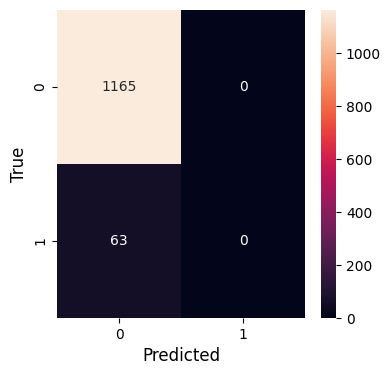

In [271]:
# Evaluate the random forest pipeline with PCA
eval_classification(rf_pipe_pca, X_train, X_test, y_train, y_test)

Train Report:
               precision    recall  f1-score   support

           0       0.99      0.72      0.83      3535
           1       0.10      0.79      0.18       146

    accuracy                           0.72      3681
   macro avg       0.55      0.75      0.51      3681
weighted avg       0.95      0.72      0.81      3681

Test Report:
               precision    recall  f1-score   support

           0       0.99      0.72      0.83      1165
           1       0.14      0.84      0.24        63

    accuracy                           0.73      1228
   macro avg       0.56      0.78      0.54      1228
weighted avg       0.94      0.73      0.80      1228



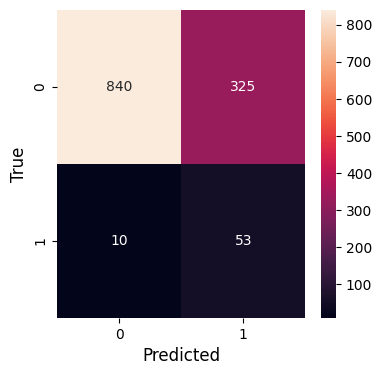

In [272]:
# Evaluate the logistic regression pipeline with POCA
eval_classification(logreg_pipe_pca, X_train, X_test, y_train, y_test)

Train Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3535
           1       1.00      1.00      1.00       146

    accuracy                           1.00      3681
   macro avg       1.00      1.00      1.00      3681
weighted avg       1.00      1.00      1.00      3681

Test Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97      1165
           1       0.44      0.06      0.11        63

    accuracy                           0.95      1228
   macro avg       0.70      0.53      0.54      1228
weighted avg       0.93      0.95      0.93      1228



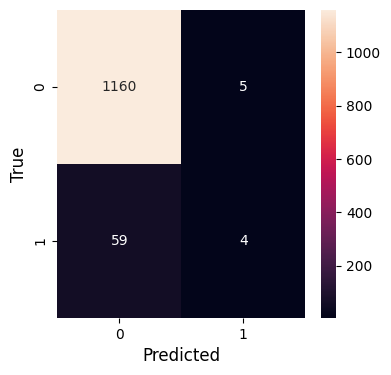

In [273]:
# Evaluate the XGBoost pipeline with PCA
eval_classification(xgb_pipe_pca, X_train, X_test, y_train, y_test)

Of all the models tested, the logistic regression classifier with PCA provided the best value for the recall measure on test data for being at risk for a stroke (0.84). The logistic regression without PCA provided almost as good a value (0.83).

The other models performed very pootly when considering the recall measure.

The logistic regression classifier performed poorly when considering false positives. If the consequences of raising a false alarm is more serious than advising (at no substantial fnancial cost) serious lifestyle changes to those classified as at-risk, other metrics need to pay a more significant role in evaluation of the models.

## Hypertuning

In [274]:
# Obtain list of parameters
logreg_pipe_pca.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('numeric',
                                    Pipeline(steps=[('standardscaler',
                                                     StandardScaler())]),
                                    Index(['age', 'avg_glucose_level', 'bmi'], dtype='object')),
                                   ('categorical',
                                    Pipeline(steps=[('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore',
                                                                   sparse_output=False))]),
                                    Index(['gender', 'ever_married', 'work_type', 'Residence_type',
          'smoking_status'],
         dtype='object'))],
                     verbose_feature_names_out=False)),
  ('pca', PCA(n_components=0.95)),
  ('logisticregression',
   LogisticRegression(C=1000, class_weight='balanced', solver='liblinear'))],
 'ver

In [275]:
# Define parameters to tune

param_grid = {'logisticregression__penalty': ['l1', 'l2'],
              'logisticregression__C':  [.0001, .001, .01, .1, 1, 10, 100, 1000, 10000]
}

# Instaniate the gridsearch
gridsearch = GridSearchCV(logreg_pipe, param_grid, n_jobs=-1, verbose=1)

# Fit the gridsearch on the training data
gridsearch.fit(X_train, y_train)

# Obtain the best parameters from the gridsearch
gridsearch.best_params_

Fitting 5 folds for each of 18 candidates, totalling 90 fits


{'logisticregression__C': 0.0001, 'logisticregression__penalty': 'l1'}

In [276]:
# Define parameters to tune with PCA

param_grid = {'logisticregression__penalty': ['l1', 'l2'],
              'logisticregression__C':  [.0001, .001, .01, .1, 1, 10, 100, 1000, 10000]
}

# Instaniate the gridsearch
gridsearch = GridSearchCV(logreg_pipe_pca, param_grid, n_jobs=-1, verbose=1)

# Fit the gridsearch on the training data
gridsearch.fit(X_train, y_train)

# Obtain the best parameters from the gridsearch
gridsearch.best_params_

Fitting 5 folds for each of 18 candidates, totalling 90 fits


{'logisticregression__C': 0.0001, 'logisticregression__penalty': 'l1'}

Train Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98      3535
           1       0.00      0.00      0.00       146

    accuracy                           0.96      3681
   macro avg       0.48      0.50      0.49      3681
weighted avg       0.92      0.96      0.94      3681

Test Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97      1165
           1       0.00      0.00      0.00        63

    accuracy                           0.95      1228
   macro avg       0.47      0.50      0.49      1228
weighted avg       0.90      0.95      0.92      1228



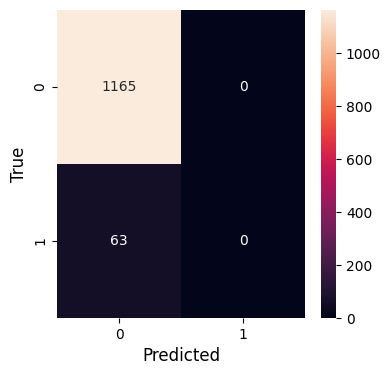

Train Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98      3535
           1       0.00      0.00      0.00       146

    accuracy                           0.96      3681
   macro avg       0.48      0.50      0.49      3681
weighted avg       0.92      0.96      0.94      3681

Test Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97      1165
           1       0.00      0.00      0.00        63

    accuracy                           0.95      1228
   macro avg       0.47      0.50      0.49      1228
weighted avg       0.90      0.95      0.92      1228



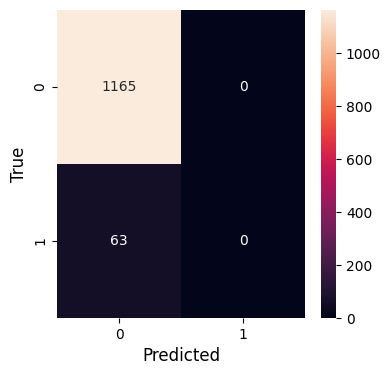

In [277]:
# Instantiate and assess hypertuned models

logreg_best = LogisticRegression(C=0.0001, max_iter=1000, solver='liblinear', penalty='l1', class_weight = 'balanced')
logreg_best_pipe = make_pipeline(col_transformer, logreg_best)
logreg_best_pipe.fit(X_train, y_train)

eval_classification(logreg_best_pipe, X_train, X_test, y_train, y_test)

logreg_pca_best = LogisticRegression(C=0.0001, max_iter=1000, solver='liblinear', penalty='l1', class_weight = 'balanced')
logreg_pca_best_pipe = make_pipeline(col_transformer, pca, logreg_pca_best)
logreg_pca_best_pipe.fit(X_train, y_train)

eval_classification(logreg_pca_best_pipe, X_train, X_test, y_train, y_test)

Gridseach did not yield model improvements as judged by the recall measure (ie prioritising the avoidance of false negatives), so the original logistic regression classifier with PCA is recommended.